# Models of the space between genres

The general goal here is to come up with a metric of similarity between models trained on different data. In particular, I want to be able to compare

* a model of genre A against a negative "contrast" set (Z)
* a model of genre B against the same set (Z)
* a model of genre C against the same set (Z),

and meaningfully say, the divergence between models A-B is greater than the divergence between B-C. In other words, models A and B don't echo each others' predictions as well as B and C. 

I don't assume that these are going to be distance metrics. E.g., I don't assume that A->B (ability of A to predict B) is always equal to B->A. In fact I know that predictive models are *not* symmetric! But I'm usually less interested in the asymmetry than in an overall measure of A-B divergence produced by averaging A->B and B->A.

I would like to interpret that measure as saying something like "genres A and B differ from Z *in different ways.*" So, for instance, I could say "Fantasy and science fiction differ from mainstream fiction in very similar ways, compared to detective fiction, which departs from the mainstream in a different direction. We know this because a model of detective fiction cannot distinguish F & SF from the mainstream, whereas F & SF are mutually predictive."

My problem is, how do I know that any measure of divergence between models correlates in a reliable fashion with the distance between genres? I mean, we could be dealing with a curve, and the curve could be entirely different for different genres. Or the relationship could be very noisy. It's not safe to assume that I'm measuring what I hope to be measuring.

#### how can we know that we're measuring the space we want to measure?

My strategy to solve this is to *construct* a space between two genres by gradually mixing the data from A with data for B. At first, we'll use 100% data from fantasy fiction 1800-1930 (tagged by Dorothy Scarborough in 1917 and/or by contemporary librarians). Then we'll replace 5% of the features in that data, randomly, with feature counts from a set of detective fiction (defined similarly by a bibliography + librarians). And then replace 10% of the data with words from detective fiction. And then 20%, and so on, until we reach 100%.

While this is an artificial procedure, it ought to be roughly analogous to what we mean by "the distance between genres." Data is being mixed in a known ratio.

Then, for each ratio setting (0%, 5%, 10% ... 90%, 95%, 100%) we train multiple models separating the mixed genre from randomly-selected (more or less "mainstream") fiction. We'll call these our mixed models.

Then we take a *separate* sample of detective fiction, fantasy fiction, and random contrast volumes, in order to construct "gold standard" models that will serve as reference points for the mixed models. 

The gold standard volumes are all selected in the same way as our mixed volumes (by the same bibliographies, etc), but we ensure that this is a separate "partition" of the data. Authors in partition 1 are not present in partition 2, and vice-versa. The reason for doing this is, we want a realistic picture of one fantasy model's ability to predict another 100% fantasy model. If we allowed data to overlap between models, we would be training on test data, and we'd get an unrealistically low baseline. (In fact, in some of my earlier experiments I was getting *negative* divergence, which was a sure sign that data was leaking from train to test.)

#### what will we analyze?

For each pairing of gold-standard model and mixed model, we will compare the accuracy lost when one side predicts data used for the other, and vice-versa. We will also compare spearman correlations between a model's predictions on its own data, and another model's predictions. These are all probabilities: continuous-valued predictions between 0 and 1.

Spearman correlations undergo a Fisher's z-transform, because previous experiments have shown that this transformation correlates better with the distance between datasets.

#### where is the code that produced the data?

Back in the ```measureperspective``` repo. The data was constructed by ```partition_for_experiment.py, mix_data.py,``` and ```copyrandom.py,``` all in the ```measurdivergence``` folder. The actual modeling, and comparing of models, was done by ```methodological_experiment.py``` in the ```logistic``` folder; see esp the functions ```.new_experiment()``` and ```.new_divergences().``` Sorry for the generic "new" naming; I couldn't think of a short way to say "better system of mixing the data."

In [62]:
# Let's start with standard imports.

import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
%matplotlib inline

In [108]:
# Read in the data and take a look. Also construct a new column that reports the average
# "alien accuracy"; that's to say the average of A's accuracy on B data and
# B's accuracy on A data. A's accuracy on A data, etc. is contained in the
# generic acc1 and acc2 columns.

df = pd.read_csv('results/new_comparisons.tsv', sep = '\t')
df = df.assign(alien = (df.alienacc1 + df.alienacc2)/2)
df.head()

,testype,name1,name2,ratio,spearman,spear1on2,spear2on1,loss,loss1on2,loss2on1,acc1,acc2,alienacc1,alienacc2,meandate1,meandate2,alien
0,fantasy2mixed,goldfantasy_0,mixeddata_0_0,0,1.058268,1.020412,1.096123,-0.023333,-0.040000,-0.006667,0.813333,0.813333,0.820000,0.853333,1892.566667,1888.706667,0.836667
1,detective2mixed,golddetective_0,mixeddata_0_0,100,0.080297,0.032722,0.127871,0.300000,0.266667,0.333333,0.906667,0.813333,0.573333,0.546667,1891.413333,1888.706667,0.560000
2,fantasy2mixed,goldfantasy_0,mixeddata_0_5,5,0.999742,1.103884,0.895601,0.020000,0.000000,0.040000,0.813333,0.833333,0.773333,0.833333,1892.566667,1889.853333,0.803333
3,detective2mixed,golddetective_0,mixeddata_0_5,95,0.244162,0.278577,0.209747,0.290000,0.213333,0.366667,0.906667,0.833333,0.540000,0.620000,1891.413333,1889.853333,0.580000
4,fantasy2mixed,goldfantasy_0,mixeddata_0_10,10,1.017118,1.005464,1.028773,0.016667,0.033333,0.000000,0.813333,0.880000,0.813333,0.846667,1892.566667,1892.026667,0.830000


In [109]:
# Halfway through the experiment, we flipped the partitions
# used to create gold standard and mixed models. This
# made a difference, so we need a way to separate comparisons
# between goldstandards from partition 1 and mixed models
# from partition 2 -- and vice versa.

# I can use iteration number as a proxy for this,
# because iterations 0-2 were made with mixed models
# from partition 2, and iterations 3-5 were made
# with the mixed models coming from partition 1.

def partitiontype(astring):
    iteration = int(astring[-1:])
    if iteration < 3:
        return "mixed2"
    else:
        return "mixed1"

df = df.assign(partype = df['name1'].apply(partitiontype))
df.shape

(468, 18)

#### Separate comparisons of mixed models to a detective baseline and to a fantasy baseline

In recording the "ratio" variable I made sure it was relative to the genre, so models with 10% detective fiction are recorded as ratio == 10 when compared to a fantasy baseline but as ratio == 90 for the detective comparison.

In [110]:
det = df.loc[df.testype == 'detective2mixed', :]
fan = df.loc[df.testype == 'fantasy2mixed', :]

### Let's see what we get with Spearman correlation

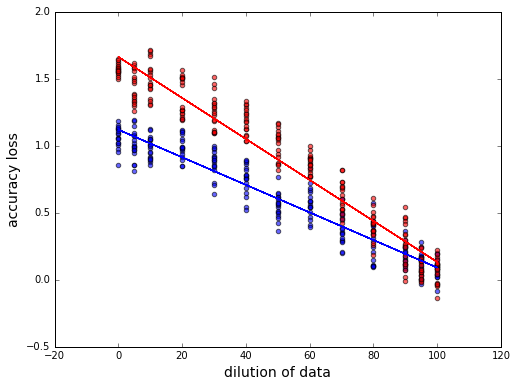

In [111]:
fig, ax = plt.subplots(figsize = (8, 6))
plt.scatter(fan.ratio, fan.spearman, c ='b', alpha = 0.6)
plt.scatter(det.ratio, det.spearman, c = 'r', alpha = 0.6)
plt.xlabel('dilution of data', fontsize = 14)
plt.ylabel('accuracy loss', fontsize = 14)


z = np.polyfit(fan.ratio, fan.spearman, 1)
p = np.poly1d(z)
ax.plot(fan.ratio, p(fan.ratio), linestyle = (0, (5, 5)), c = 'b')

z = np.polyfit(det.ratio, det.spearman, 1)
p = np.poly1d(z)
ax.plot(det.ratio, p(det.ratio), linestyle = (0, (5, 5)), c = 'r')

plt.show()

#### analysis

Yikes. It's a linear relationship, but the slope of the line varies from one genre to another. Detective fiction is a very coherent genre, and models of detective fiction always predict each other better than models of fantasy do. They can be reduced to equality (since when the data is 100% diluted, prediction is little better than random). But for anything short of complete randomness, the lines are different.

### Normalized Spearman

Can we solve this? Yes, probably. Let's just control for the initial difference of correlation strength when models are trained on the same genre.

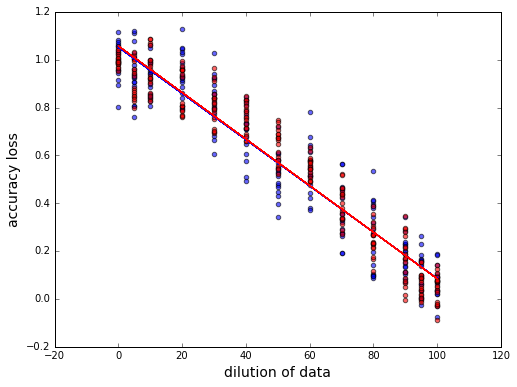

In [144]:
best_fantasy_self = np.mean(fan.spearman[fan.ratio == 0])
best_detective_self = np.mean(det.spearman[det.ratio == 0])

fig, ax = plt.subplots(figsize = (8, 6))
plt.scatter(fan.ratio, fan.spearman/best_fantasy_self, c ='b', alpha = 0.6)
plt.scatter(det.ratio, det.spearman/best_detective_self, c = 'r', alpha = 0.6)
plt.xlabel('dilution of data', fontsize = 14)
plt.ylabel('accuracy loss', fontsize = 14)


z = np.polyfit(fan.ratio, fan.spearman/best_fantasy_self, 1)
p = np.poly1d(z)
ax.plot(fan.ratio, p(fan.ratio), linestyle = (0, (5, 5)), c = 'b')

z = np.polyfit(det.ratio, det.spearman/best_detective_self, 1)
p = np.poly1d(z)
ax.plot(det.ratio, p(det.ratio), linestyle = (0, (5, 5)), c = 'r')

plt.show()

#### analysis

It's not perfect, but actually it's pretty darn good. There *is* a blue line in that graph; it just got split by the red line like a fricking arrow in a Robin Hood competition.

In [145]:
pearsonr(fan.ratio.append(det.ratio), (fan.spearman/best_fantasy_self).append(det.spearman/best_detective_self))

(-0.95959733131878511, 8.9900279147737992e-259)

Let's add that in as a column to the original data frame.

In [146]:
fan = fan.assign(normspear = fan.spearman/best_fantasy_self)
det = det.assign(normspear = det.spearman/best_detective_self)
df = pd.concat([fan, det])

### Lost accuracy

The absolute amount of accuracy lost from one model to another is also very strongly correlated with the known amount of overlap between their data. (This is a positive correlation, because we're talking about loss -- which increases with distance -- rather than strength of correlation, which declines.) This measure doesn't have the problematic divergence between genres we saw with Spearman correlation.

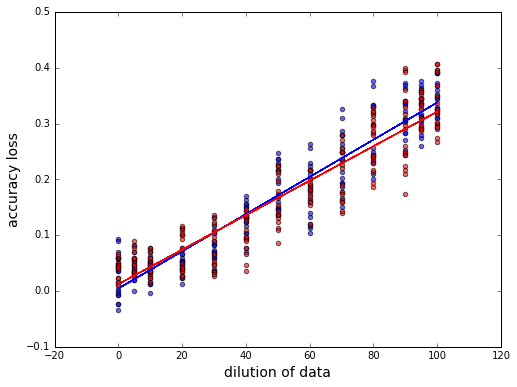

In [147]:
fig, ax = plt.subplots(figsize = (8, 6))
plt.scatter(fan.ratio, fan.loss, c ='b', alpha = 0.6)
plt.scatter(det.ratio, det.loss, c = 'r', alpha = 0.6)
plt.xlabel('dilution of data', fontsize = 14)
plt.ylabel('accuracy loss', fontsize = 14)


z = np.polyfit(fan.ratio, fan.loss, 1)
p = np.poly1d(z)
ax.plot(fan.ratio, p(fan.ratio), linestyle = (0, (5, 5)), c = 'b')

z = np.polyfit(det.ratio, det.loss, 1)
p = np.poly1d(z)
ax.plot(det.ratio, p(det.ratio), linestyle = (0, (5, 5)), c = 'r')

plt.show()

#### analysis

But notice that there's a problematic flatness to the data at low levels of dilution, suggesting that this measure is not super-sensitive. Across the whole span, it competes well with Spearman. r = .94 and r = .-96 are competitive.

In [116]:
pearsonr(df.ratio, df.loss)

(0.93715864704792851, 3.135229476499021e-215)

But if we consider just the first three notches on the X axis -- neither metric is great, but ```normspear``` is clearly better.

In [149]:
pearsonr(df.ratio[df.ratio < 20], df.loss[df.ratio < 20])

(0.16191770581944304, 0.094094286644381214)

In [148]:
pearsonr(df.ratio[df.ratio < 20], df.normspear[df.ratio < 20])

(-0.29810501207789464, 0.0017272483115845761)

### How robust are these measures?

We have an easy way to check this. Since I divided data into two partitions, using each partition alternately for a gold standard or for a source of "mixed" data, we can assess how small variations change the picture. For instance, suppose we consider just the half of the data where mixed data came from partition 2.

In [150]:
f2 = fan.loc[fan.partype == 'mixed2', : ]
d2 = det.loc[det.partype == 'mixed2', : ]

Normalized spearman is no longer independent of genre here.

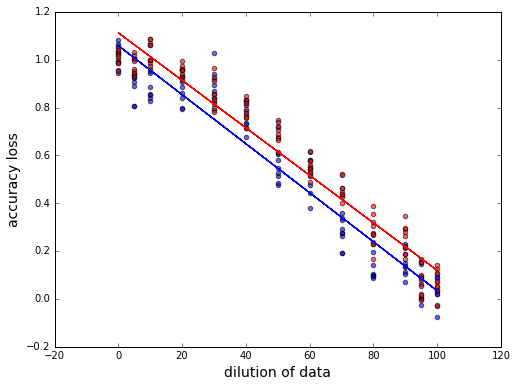

In [151]:
fig, ax = plt.subplots(figsize = (8, 6))
plt.scatter(f2.ratio, f2.normspear, c ='b', alpha = 0.6)
plt.scatter(d2.ratio, d2.normspear, c = 'r', alpha = 0.6)
plt.xlabel('dilution of data', fontsize = 14)
plt.ylabel('accuracy loss', fontsize = 14)

z = np.polyfit(f2.ratio, f2.normspear, 1)
p = np.poly1d(z)
ax.plot(f2.ratio, p(f2.ratio), linestyle = (0, (5, 5)), c = 'b')

z = np.polyfit(d2.ratio, d2.normspear, 1)
p = np.poly1d(z)
ax.plot(d2.ratio, p(d2.ratio), linestyle = (0, (5, 5)), c = 'r')

plt.show()

And yowch, we get some real problem with absolute loss as a measurement at high levels of dilution.

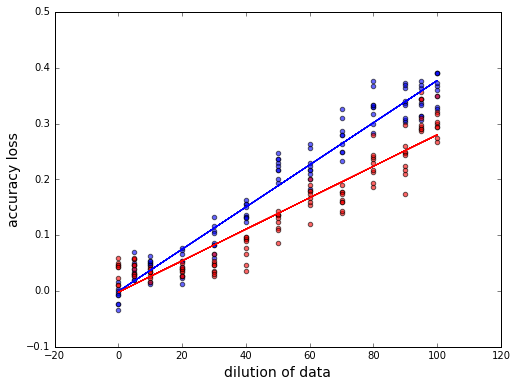

In [135]:
fig, ax = plt.subplots(figsize = (8, 6))
plt.scatter(f2.ratio, f2.loss, c ='b', alpha = 0.6)
plt.scatter(d2.ratio, d2.loss, c = 'r', alpha = 0.6)
plt.xlabel('dilution of data', fontsize = 14)
plt.ylabel('accuracy loss', fontsize = 14)

z = np.polyfit(f2.ratio, f2.loss, 1)
p = np.poly1d(z)
ax.plot(f2.ratio, p(f2.ratio), linestyle = (0, (5, 5)), c = 'b')

z = np.polyfit(d2.ratio, d2.loss, 1)
p = np.poly1d(z)
ax.plot(d2.ratio, p(d2.ratio), linestyle = (0, (5, 5)), c = 'r')

plt.show()

### Conclusion

Probably the best overall measure is mean Spearman correlation between models, undergoing a Fisher's z-transform to render the measure more linear at high values r > .9, and normalized for the mean Spearman's correlation of a genre on itself (using non-overlapping data samples!!). 

The fraction 

    CrossSpearman / MeanSelfSpearman

could reasonably be interpreted as a measure of similarity between genres.

But do realize that this is not a perfect measure. I've tried it on two genres. Really, lots more experiments should be run on others; I don't think this is mathematically guaranteed to work. The particular random sample you take can matter, so it's advisable to repeatedly partition the data in different ways, make comparisons between pairs of models, and work with the *mean* Spearman correlation between genres divided by the *mean* correlation of a genre on itself.

This should be tested further, but right now, for the normalizing factor, I would recommend using whichever genre has a higher mean correlation -- I would not average the two.

#### a linear model

In [152]:
lm = smf.ols(formula='ratio ~ normspear', data=df).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  ratio   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     5420.
Date:                Mon, 01 Jan 2018   Prob (F-statistic):          8.99e-259
Time:                        13:15:45   Log-Likelihood:                -1721.3
No. Observations:                 468   AIC:                             3447.
Df Residuals:                     466   BIC:                             3455.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    104.1294      0.859    121.270      0.000     102.442     105.817
normspear    -94.9056      1.289    -73.620      0.000     -97.439     -92.372
==============================================================================
Omnibus:                        2.144   Durbin-Watson:                   1.172
Prob(Omnibus):                  0.342   Jarque-Bera (JB):                1.883
Skew:                          -0.043   Prob(JB):                        0.390
Kurtosis:                       2.701   Cond. No.                         3.94
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""